<a href="https://colab.research.google.com/github/scarabinoalbano/07MIAR_04_A_2025-26_Redes-Neuronales-y-Deep-Learning/blob/main/07MIAR_Proyecto_Programacion_Grupo8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de Programación "*Deep Vision in classification tasks*"

## Integrantes:
 - Adrián Ortiz Martínez
 - Albano Andrés Scarabino Guissani
 - Gonzalo Rosas Ortiz
 - Alumno 4

In [74]:
#Importamos librerías de propóstio general
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import random

## Carga y Análisis de datos

Como se ha visto a lo largo de este curso, el correcto diseño de una red neuronal se base principalmente en un buen análisis de datos, esto con el objetivo de conocer la calidad de la información y definir las acciones posteriores.

In [75]:
# Montamos conexión a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# Analizamos el DataFrame
df_path = '/content/drive/MyDrive/datase_set/train.csv'
df = pd.read_csv(df_path,sep='|')
display(df.groupby('folder')['folder'].count().sort_values(ascending=False))

,folder
folder,
Loose Silky-bent,654
Common Chickweed,611
Scentless Mayweed,516
Small-flowered Cranesbill,496
Fat Hen,475
Charlock,390
Sugar beet,385
Cleavers,287
Black-grass,263


De la tabla anterior se procede a resltar los siguientes puntos:
- Se cuenta con un dataset que consta de 4750 imágenes, revisando el estado del arte, podríamos considerar nuestro dataset como mediano.
- Se observa un desbalanceo importante entre clases, reportando un número de 654 en la clase mayoritaria y 221 en la clase minoritaría.

Los puntos anteriores son de suma importancia porque nos dan un indicio de los pasos a realizar previos a la fase de entrenamiento, dichos pasos se detallan en la siguiente sección.

## Preprocesamiento de Imagenes

En la sección anterior se mencionó que debido al númeor de muestras en el dataset, este podría ser considerado como mediano,consultando el estado del arte, se puede resaltar las siguientes tareas previo al entrenamiento del modelo:

1. Data Augmentation
  - Rotación
  - Traslación
  - Flip
  - Cambio de brillo
2. Escala de Imágenes
3. Normalización

Por lo anterior, procedemos a implementar dichas tareas en las funciones que se muestran a continuación:

In [77]:
def data_augmentation(image):

    img = tf.image.random_flip_left_right(image)
    img = tf.cond(tf.random.uniform([]) < 0.3, lambda : tf.image.random_flip_up_down(img), lambda : img)
    img = tf.cond(tf.random.uniform([]) < 0.3, lambda : tf.image.random_brightness(img,max_delta=0.2), lambda : img)
    img = tf.cond(tf.random.uniform([]) < 0.4, lambda : tf.image.random_contrast(img,lower=0.8,upper=1.2), lambda : img)
    img = tf.image.rot90(img,k = np.random.randint(1,4))

    return img

# Función que convierte la función de carga a tf.function para optimizarla

def tf_load_image(path, label,is_training=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)

    if is_training : img = data_augmentation(img)

    img = tf.image.resize(img,size=[224,224],method='lanczos3')
    img = img / 255.0
    label = tf.one_hot(label,depth=12)
    return img, label

## 1. Pipelines para lectura de datos

In [78]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

El primer paso es realizar one-hot encoding, este proceso se hace debido a las siguientes razones:
1. El dataset no contiene ningún archivo .csv que nos indique las clases de salida.
2. El dataset está organizado en carpetas y dentro de ellas, encontramos las imágenes.

Es por lo anterior que, tomamos como salida el nombre de cada folder que conforma el dataset y lo transformamos en una variables cuantitativa que el modelo pueda usar.

In [79]:
extract_path = '/content/drive/MyDrive/datase_set/'
# Realizamos proceso de one-hot encoding para discretizar las clases del dataset
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['folder'])
df['path'] = df.apply(lambda row : os.path.join(extract_path,'train',row['folder'],row['file_name']),axis=1)
display(df)

,file_name,folder,length,width,label,path
0,0050f38b3.png,Black-grass,196,196,0,/content/drive/MyDrive/datase_set/train/Black-...
1,0183fdf68.png,Black-grass,388,388,0,/content/drive/MyDrive/datase_set/train/Black-...
2,0260cffa8.png,Black-grass,886,886,0,/content/drive/MyDrive/datase_set/train/Black-...
3,05eedce4d.png,Black-grass,117,117,0,/content/drive/MyDrive/datase_set/train/Black-...
4,075d004bc.png,Black-grass,471,471,0,/content/drive/MyDrive/datase_set/train/Black-...
...,...,...,...,...,...,...
4745,fc293eacb.png,Sugar beet,548,548,11,/content/drive/MyDrive/datase_set/train/Sugar ...
4746,fc441208c.png,Sugar beet,182,182,11,/content/drive/MyDrive/datase_set/train/Sugar ...
4747,fed9406b2.png,Sugar beet,431,431,11,/content/drive/MyDrive/datase_set/train/Sugar ...
4748,fef5e7066.png,Sugar beet,1005,1005,11,/content/drive/MyDrive/datase_set/train/Sugar ...


In [ ]:
# Obtener los conteos por categoría
counts = df.groupby('folder')['folder'].count().to_dict()

# Ordenar categorías por frecuencia (de mayor a menor)
sorted_categories = sorted(counts.items(), key=lambda x: x[1], reverse=True)
categories_sorted = [x[0] for x in sorted_categories]
values_sorted = [x[1] for x in sorted_categories]

# Crear la figura
plt.figure(figsize=(12, 7))
bars = plt.bar(range(len(categories_sorted)), values_sorted,
               color=sns.color_palette('viridis', len(categories_sorted)))

# Etiquetas en el eje X
plt.xticks(range(len(categories_sorted)), categories_sorted, rotation=45, ha='right')

# Añadir valores y porcentajes sobre cada barra
total = sum(values_sorted)
for i, (cat, val) in enumerate(zip(categories_sorted, values_sorted)):
    percentage = '{:.1f}%'.format(100 * val / total)
    plt.text(i, val + max(values_sorted)*0.02, f'{val}\n{percentage}',
             ha='center', va='bottom', fontsize=9)

# Ajustar límites del eje Y para que se vean los textos
max_value = max(values_sorted)
plt.ylim(0, max_value * 1.15)

# Títulos y etiquetas
plt.title('Distribución de imágenes por categoría', fontsize=14, fontweight='bold')
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Cantidad de imágenes', fontsize=12)
plt.tight_layout()

# Estadísticas
print(f"Total de imágenes: {total}")
print(f"Número de clases: {len(categories_sorted)}")
print(f"Promedio por clase: {total/len(categories_sorted):.1f}")
print(f"Clase más frecuente: {categories_sorted[0]} ({values_sorted[0]} imágenes)")
print(f"Clase menos frecuente: {categories_sorted[-1]} ({values_sorted[-1]} imágenes)")

plt.show()

In [ ]:
def plot_samples_grid(df, samples_per_category=4):
    categories = sorted(df['folder'].unique())
    rows = len(categories)
    cols = samples_per_category

    fig = plt.figure(figsize=(cols * 3.5, rows * 3))

    for i, category in enumerate(categories):
        # Filtrar imágenes de esta categoría
        category_df = df[df['folder'] == category]
        # Seleccionar muestras aleatorias
        sample_df = category_df.sample(n=min(samples_per_category, len(category_df)), random_state=42)

        category_name = category.replace('_', ' ').replace('-', ' ')

        for j, (idx, row) in enumerate(sample_df.iterrows()):
            ax = plt.subplot(rows, cols, i * cols + j + 1)

            # Cargar y mostrar la imagen
            img = Image.open(row['path'])
            ax.imshow(img)
            ax.axis('off')

            if j == 0:
                ax.text(-0.1, 0.5, category_name,
                       transform=ax.transAxes,
                       rotation=90,
                       fontsize=12,
                       fontweight='bold',
                       ha='right',
                       va='center')

    plt.suptitle('Muestras de imágenes por categoría',
                 fontsize=16, fontweight='bold')
    plt.subplots_adjust(left=0.15, top=0.95, hspace=0.3, wspace=0.1)
    plt.show()

plot_samples_grid(df, samples_per_category=4)

Procedemos a realizar una partición externa 80-20% estratificada, asegurandonos de que los conjuntos de entrenamiento y validación conserven la misma proporción que en el dataset original.

In [80]:
#Panteamos una validación Hold-Out externa
X_train,X_test,y_train,y_test = train_test_split(df['path'],df['label'],test_size=0.2,stratify=df['label'],random_state=42)

#Creamos Test de validación
X_dev_train, X_val, y_dev_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Una vez realizada la partición externa, procedemos a definir el pipeline para el pre-procesamiento del dataset, lo que se busca con este pipeline es proveer al modelo con un dataset variado en cada época y lograr así, una buena generalización sobre el dataset.

In [81]:
#Creamos pipeline para lectura de datos
train_dataset = tf.data.Dataset.from_tensor_slices((X_dev_train.values,y_dev_train.values))
train_dataset = train_dataset.map(lambda x,y : tf_load_image(x,y,is_training=True), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values,y_val.values))
val_dataset = val_dataset.map(tf_load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values,y_test.values))
test_dataset = test_dataset.map(tf_load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## 2. Diseño de Modelo desde Cero

Para el modelo desde cero se propone una red neuronal con las siguientes características:


1.   3 bloques para la obtención de características principales de tipo: CONV+BN+DP
2.   1 Capa de Global AvergaPooling para "apilar" las imagenes resultantes despues del filtrado.
3. 2 bloques de tipo Dense+DP para la reduccir las dimensiones de nuestro proceso de análisis y evitar overfitting.



In [ ]:
#Importamos librerías para diseñar la red neuronal
from tensorflow.keras import layers,models,regularizers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def image_classificator():

    input_layer = layers.Input(shape=(224,224,3)) # Definimos capa de entrada

    '''Primer bloque de convolución, iniciamos con 16 filtros, kernel de 3x3 y strides de 1 para captar la mayor
    de la imagen, al termino de este bloque, reducimos la imagen a la mitad, aplicamos un dropout al 0.2
    '''
    x1 = layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(input_layer)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPool2D(pool_size=2)(x1)
    x1 = layers.Dropout(rate=0.2)(x1)

    '''
    En el segundo bloque iniciamos con 32 filtros
    '''
    x2 = layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPool2D(pool_size=2)(x2)
    x2 = layers.Dropout(rate=0.2)(x2)

    '''
    En el tercer bloque iniciamos con 64 filtros
    '''
    x3 = layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.MaxPool2D(pool_size=2)(x3)


    #Aplanamos el resultado de la capa anterior
    x4 = layers.GlobalAveragePooling2D()(x3)

    #Iniciamos la etapa de deconstrucción, aquí aplicaremos un droput decremental

    x5 = layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x4)
    x5 = layers.Dropout(rate=0.2)(x5)

    x6 = layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x5)
    x6 = layers.Dropout(rate=0.2)(x6)

    x7 = layers.Dense(12)(x6) #unidad de 12 porque son 12 clases a predecir

    #Generamos salida
    output_layer = layers.Activation('softmax')(x7)

    return models.Model(inputs=input_layer,outputs=output_layer)

### 2.1 Entrenamiento de Modelo

In [ ]:
#Importamos funciones de Callback y métricas para el entrenamiento
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

Declaramos métricas:

In [ ]:
metricas=[
  metrics.Precision(name='precision'),
  metrics.Recall(name='recall'),
  metrics.AUC(name='auc'),
  metrics.F1Score( average='macro', name='f1_macro'),
  'accuracy'
]

Declaramos callbacks para monitorizar el entrenamiento:

In [ ]:
#Callback para guardar mejor versión del modelo durante el entrenamiento
checkpoint_sm = ModelCheckpoint(
    filepath='scratch_model2.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#Callback para detener el entrenamiento si el accuracy no mejora tras 7 épocas consecutivas
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

De la sección de Carga y Análisis de datos se observa que nuestro dataset está desbalanceado, lo cual, podría afectar negativamente el entrenamiento y rendimiento final del modelo, es por ello que, como último paso antes de proceder al entrenamiento del modelo se realizará un balanceo de clases, esto nos ayudara a asegurarnos de que el modelo ajuste los parámetros en cada época en torno a la proporción de muestras por clase.

In [ ]:
y_classes = np.unique(df['label'],return_counts=False)
weights = compute_class_weight(class_weight='balanced',classes=y_classes,y=df['label'])
class_weight_dict = {}
for i in range(0,len(y_classes)):
    class_weight_dict[int(y_classes[i])] = float(np.round(weights[i],3))
print(class_weight_dict)

{0: 1.505, 1: 1.015, 2: 1.379, 3: 0.648, 4: 1.791, 5: 0.833, 6: 0.605, 7: 1.791, 8: 0.767, 9: 1.714, 10: 0.798, 11: 1.028}


Nos aseguramos de realizar el entrenamiento meidante el uso debGPU para ahorrar tiempo en esta fase

In [ ]:
from tensorflow.python.client import device_lib
!nvidia-smi

print(tf.test.gpu_device_name())
device_lib.list_local_devices()

Fri Nov 14 09:25:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P0             29W /   70W |    2202MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13628294476181035459
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 753868379337126380
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

Entrenamiento

In [ ]:
#Compilamos Modelo

with tf.device('/GPU:0'):
    model = image_classificator()
    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metricas
    )

In [ ]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping,checkpoint_sm],
    class_weight=class_weight_dict
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0929 - auc: 0.5292 - f1_macro: 0.0808 - loss: 2.5253 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.08158, saving model to scratch_model2.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.0932 - auc: 0.5297 - f1_macro: 0.0810 - loss: 2.5245 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0816 - val_auc: 0.4739 - val_f1_macro: 0.0126 - val_loss: 2.5132 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.1968 - auc: 0.6877 - f1_macro: 0.1695 - loss: 2.2933 - precision: 0.4502 - recall: 0.0020
Epoch 2: val_accuracy did not improve from 0.08158
95/95 ━━━━━━━━━━━━━━━━━━━━ 68s 528ms/step - accuracy: 0.1969 - auc: 0.6879 - f1_macro: 0.1696 - loss: 2.2929 - precision: 0.4526 - recall: 0.0020 - val_accuracy: 0.0592 - val_auc: 0.4789 - val_f1_macro: 0.0215 - val_loss: 2.5474 - val_precision: 0.0000e+

### 2.2 Validación de Resultados



In [ ]:
#Función para gráficar Historico de entrenamiento

def plot_training(history_training,model_name):
  fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,8))
  axes[0].plot(history_training.history['loss'], label='Entrenamiento')
  axes[0].plot(history_training.history['val_loss'], label='Validación')
  axes[0].set_title(f"Pérdida durante el entrenamiento - {model_name}")
  axes[0].set_xlabel('Épocas')
  axes[0].set_ylabel('Precisión')
  axes[0].legend()

  axes[1].plot(history_training.history['accuracy'], label='Entrenamiento')
  axes[1].plot(history_training.history['val_accuracy'], label='Validación')
  axes[1].set_title(f"Precisión durante el entrenamiento - {model_name}")
  axes[1].set_xlabel('Épocas')
  axes[1].set_ylabel('Precisión')
  axes[1].legend()


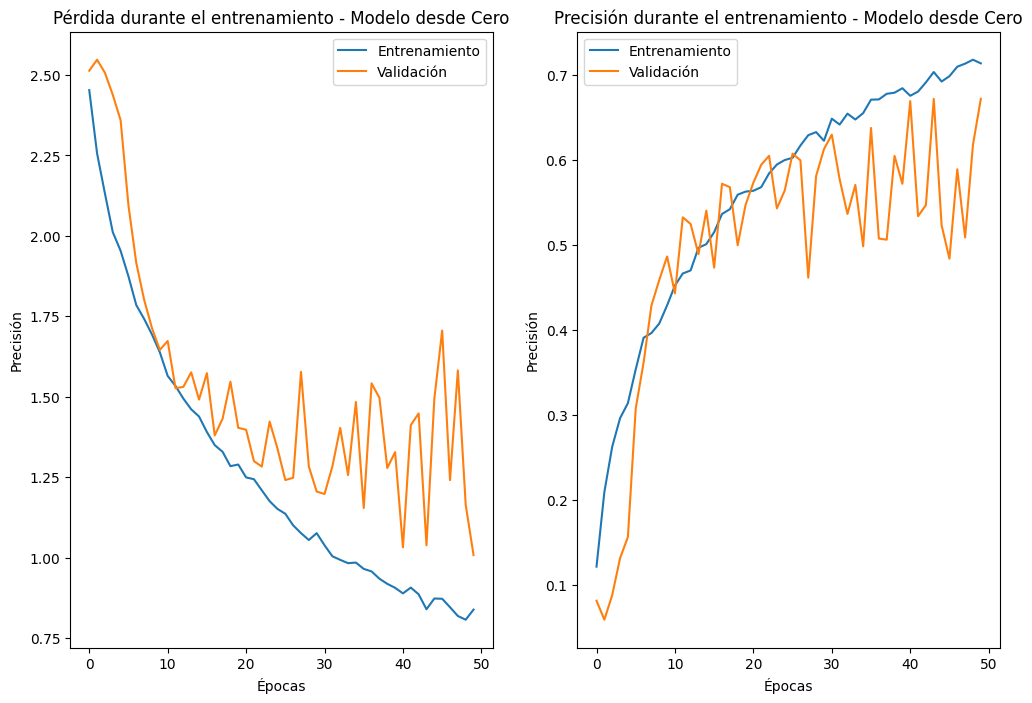

In [ ]:
plot_training(history, 'Modelo desde Cero')

Guardamos los pesos del modelo

In [64]:
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/models/'
os.makedirs(MODEL_DIR, exist_ok=True)

weights_path = os.path.join(MODEL_DIR, 'model.weights.h5')
model.save_weights(weights_path)
print(f"Pesos guardados: {weights_path}")

Pesos guardados: /content/drive/MyDrive/Colab Notebooks/models/model.weights.h5


Evaluando el modelo de predicción con las imágenes de test

In [42]:
from sklearn.metrics import classification_report

predictions = model.predict(test_dataset, batch_size=32)
print(classification_report(y_test, predictions.argmax(axis=1)))

[INFO]: Evaluando red neuronal...
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 830ms/step
              precision    recall  f1-score   support

           0       0.37      0.60      0.46        53
           1       0.61      0.90      0.73        78
           2       0.77      0.74      0.75        58
           3       1.00      0.52      0.68       122
           4       0.59      0.95      0.73        44
           5       0.79      0.65      0.72        95
           6       0.78      0.52      0.62       131
           7       0.48      0.89      0.62        44
           8       0.68      0.74      0.71       103
           9       0.50      0.04      0.08        46
          10       0.69      0.77      0.73        99
          11       0.77      0.87      0.82        77

    accuracy                           0.67       950
   macro avg       0.67      0.68      0.64       950
weighted avg       0.72      0.67      0.66       950



## 3. Transfer Learning y Fine Tunning

### 3.1 Selección de Modelos

Para este apartado, procedemos a visitar la documentación de ***keras.applications*** y extraemos la información más relevante de los modelos a elegir, los resultados se muestran a continuación:

| Modelo | # Parámetros | Profundidad |
| -  | - | - |
| Xception | 22.9 M | 81  |
| VGG16 | 138.4 M | 16  |
| VGG19 | 143.7 M | 19  |
| ResNet50 | 25.6 M | 107  |
| InceptionV3 | 23.9 M | 189  |
| InceptionResNetV2 | 55.9 M | 449  |
| MobileNetV2 | 3.5 M | 105  |
| DenseNet1211 | 8.1 M | 242  |

De la tabla anterior y retomando de la sección de Análisis de Datos, se observa que la mayoría de modelos preentrenados son demasiado complejos para la tarea de clasificar 12 tipos de plantas, lo cual, nos llevaría a problemas de over y underfitting durante el entrenamiento, es por esto que, para efectos de esta práctica los modelos seleccionados son las siguientes:

- MobileNetV2
- DenseNet121

In [82]:
#Importamos Modelos Entrenados
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121

### 3.2 Transfer Learning

Dado que los modelos seleccionados no parecen tener una arquitectura muy compleja para nuestra tarea de clasificación, la primera estrategia consiste en hacer transfer learning donde haremos uso del modelo en su totalidad y solo añadirémos unas capas a la salida para adaptarlo a la clasificación de 12 clases.

In [83]:
# Instanciamos modelos omitiendo la salida y usando los pesos del dataset ImageNet
mn_base = MobileNetV2(weights="imagenet",classes=12,include_top=False,input_shape=(224,224,3))
denset_base = DenseNet121(weights="imagenet",classes=12,include_top=False,input_shape=(224,224,3))

Congelamos los modelos base para evitar actualizar sus pesos durante el entrenamiento:

In [84]:
#Declaramos la base de ambos modelos como no entrenables puesto que haremos transfer learning
mn_base.trainable = False
denset_base.trainable = False

Añadimos capas finales al modelo MobileNetV2

In [85]:
x_mn = mn_base.output
x_mn = layers.GlobalAveragePooling2D()(x_mn)
x_mn = layers.Dropout(rate=0.3)(x_mn)
x_mn = layers.Dense(12)(x_mn)

#Generamos salida
output_layer_mn = layers.Activation('softmax')(x_mn)
mn_model = Model(inputs=mn_base.input,outputs=output_layer_mn)

#Mostramos Summary
mn_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Repetimos proceso para DenseNet121

In [86]:
x_dn = denset_base.output
x_dn = layers.GlobalAveragePooling2D()(x_dn)
x_dn = layers.Dropout(rate=0.3)(x_dn)

x_dn = layers.Dense(12)(x_dn) #unidad de 12 porque son 12 clases a predecir

#Generamos salida
output_layer_dn = layers.Activation('softmax')(x_dn)
dn_model = Model(inputs=denset_base.input,outputs=output_layer_dn)

#Mostramos Summary
dn_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,049,804 (26.89 MB)

 Trainable params: 12,300 (48.05 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

#### 3.2.1 Entrenamiento

In [87]:
#Compilamos Modelos

with tf.device('/GPU:0'):
  optimizer = Adam(learning_rate=0.0001)
  mn_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=metricas)

In [88]:
#Compilamos Modelos

with tf.device('/GPU:0'):
  optimizer = Adam(learning_rate=0.0001)
  dn_model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=metricas)

In [ ]:
history_mn = mn_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 100s 667ms/step - accuracy: 0.1069 - auc: 0.7716 - f1_macro: 0.3597 - loss: 3.0417 - precision: 0.6745 - recall: 0.2951 - val_accuracy: 0.2342 - val_auc: 0.7018 - val_f1_macro: 0.2105 - val_loss: 2.2505 - val_precision: 0.4000 - val_recall: 0.0026
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 115s 524ms/step - accuracy: 0.1963 - auc: 0.6691 - f1_macro: 0.1855 - loss: 2.4495 - precision: 0.3199 - recall: 0.0291 - val_accuracy: 0.3303 - val_auc: 0.8005 - val_f1_macro: 0.3009 - val_loss: 1.9774 - val_precision: 0.8438 - val_recall: 0.0355
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.2660 - auc: 0.7562 - f1_macro: 0.2565 - loss: 2.1127 - precision: 0.4997 - recall: 0.0568 - val_accuracy: 0.3961 - val_auc: 0.8489 - val_f1_macro: 0.3697 - val_loss: 1.7947 - val_precision: 0.8302 - val_recall: 0.0579
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 515ms/step - accuracy: 0.3288 - auc: 0.7952 - f1_macro: 0.3192 - loss: 1.9831 - precision: 0.5341

In [ ]:
history_dn = dn_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

#### 3.2.2 Validación de Resultados

In [ ]:
plot_training(history_mn,'MobileNetV2')

In [ ]:
plot_training(history_dn,'DenseNet121')

In [ ]:
mn_test = mn_model.predict(test_dataset, batch_size=32)
print(classification_report(y_test, mn_test.argmax(axis=1)))

In [ ]:
dn_test = dn_model.predict(test_dataset, batch_size=32)
print(classification_report(y_test, dn_test.argmax(axis=1)))

Guardamos los pesos de los modelos

In [ ]:
weights_path = os.path.join(MODEL_DIR, 'mn_model.weights.h5')
mn_model.save_weights(weights_path)
print(f"Pesos guardados: {weights_path}")

In [ ]:
weights_path = os.path.join(MODEL_DIR, 'dn_model.weights.h5')
dn_model.save_weights(weights_path)
print(f"Pesos guardados: {weights_path}")

### 3.3 Fine Tunning



#### 3.3.1 Entrenamiento

#### 3.3.2 Validación de Resultados

## 4. Comparativa: Modelo desde cero vs Modelos Pre-entrenado

Para está sección, usaremos como métrica de decisión la matriz de confusión para determinar que modelo fue el mejor duanrte el desarrollo de la práctica. Iniciamos con el modelo entrenado desde 0:

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

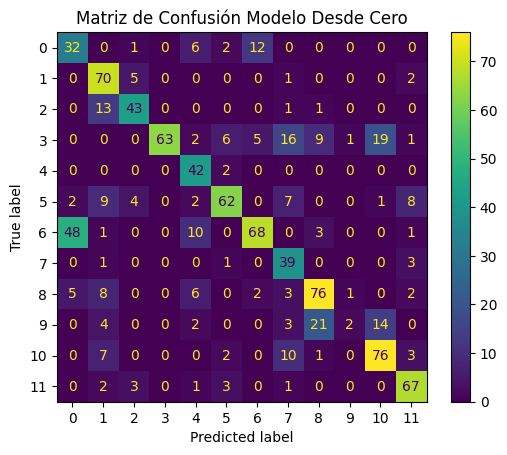

In [66]:
y_pred_model = np.argmax(predictions, axis=1)
cf_model = confusion_matrix(y_test,y_pred_model)

mn_disp = ConfusionMatrixDisplay(cf_model)
mn_disp.plot()
plt.title('Matriz de Confusión Modelo Desde Cero')
plt.show()

Seguimos con los modelos pre-entrenados + transfer learning:

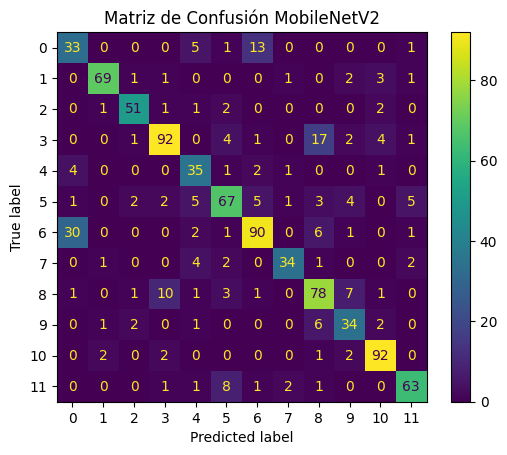

In [ ]:
y_pred_mn = np.argmax(mn_test, axis=1)
cf_mn = confusion_matrix(y_test,y_pred_mn)

mn_disp = ConfusionMatrixDisplay(cf_mn)
mn_disp.plot()
plt.title('Matriz de Confusión MobileNetV2')
plt.show()

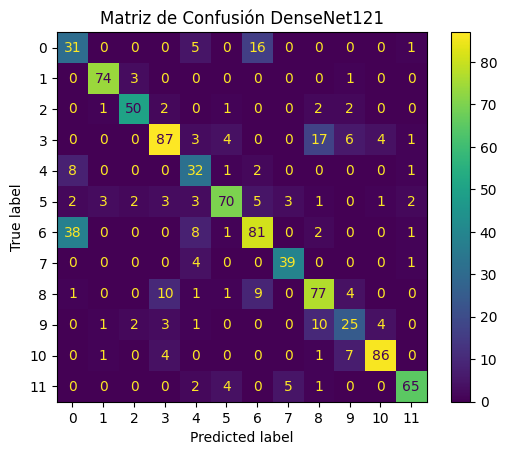

In [ ]:
y_pred_dn = np.argmax(dn_test, axis=1)
cf_dn = confusion_matrix(y_test,y_pred_dn)

dn_disp = ConfusionMatrixDisplay(cf_dn)
dn_disp.plot()
plt.title('Matriz de Confusión DenseNet121')
plt.show()

Finalmente agregamos los modelos pre-entrenados con fine tunning:

De las gráficas anterios se observa que el modelo con mejor desempeño y, el cual, se podría poner en producción es:  #Insertar modelo ganador.

## 5. Apéndice de Experimentación

## 5.1 Evaluación de modelos alternativos

#### 5.1.1 Se diseña un modelo con capas extras y mayor número de filtros

In [ ]:
def image_classificator_alternative_1():

    inputs = layers.Input(shape=(224, 224, 3))

    # Bloque 1: 32 filtros
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    # Bloque 2: 64 filtros
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Bloque 3: 128 filtros
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Bloque 4: 256 filtros
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.Dropout(0.3)(x)

    # Output
    outputs = layers.Dense(12, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

Declaramos métricas:

In [ ]:
metricas=[
  metrics.Precision(name='precision'),
  metrics.Recall(name='recall'),
  metrics.AUC(name='auc'),
  metrics.F1Score( average='macro', name='f1_macro'),
  'accuracy'
]

Declaramos callbacks para monitorizar el entrenamiento:

In [ ]:
#Callback para guardar mejor versión del modelo durante el entrenamiento
checkpoint_alt_1 = ModelCheckpoint(
    filepath='scratch_model_alternative_1.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#Callback para detener el entrenamiento si el accuracy no mejora tras 7 épocas consecutivas
early_stopping_alt_1 = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

Entrenamiento

In [ ]:
#Compilamos Modelo
with tf.device('/GPU:0'):
    model_aternative_1 = image_classificator_alternative_1()
    optimizer = Adam(learning_rate=0.0001)
    model_aternative_1.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metricas
    )

In [ ]:
#Entrenamos el modelo
history_alternative_1 = model_aternative_1.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping_alt_1,checkpoint_alt_1],
    class_weight=class_weight_dict
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.1384 - auc: 0.7882 - f1_macro: 0.3488 - loss: 2.7202 - precision: 0.7145 - recall: 0.2215
Epoch 1: val_accuracy improved from -inf to 0.08158, saving model to scratch_model_alternative_1.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 101s 668ms/step - accuracy: 0.1389 - auc: 0.7879 - f1_macro: 0.3481 - loss: 2.7169 - precision: 0.7142 - recall: 0.2204 - val_accuracy: 0.0816 - val_auc: 0.4941 - val_f1_macro: 0.0126 - val_loss: 2.6692 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.3090 - auc: 0.8109 - f1_macro: 0.3053 - loss: 1.9883 - precision: 0.5867 - recall: 0.0634
Epoch 2: val_accuracy improved from 0.08158 to 0.10921, saving model to scratch_model_alternative_1.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 73s 584ms/step - accuracy: 0.3094 - auc: 0.8111 - f1_macro: 0.3056 - loss: 1.9876 - precision: 0.5867 - recall: 0.0635 - val_accuracy: 0.1092 - val_auc: 0.5483 - val_f1_

Evaluación



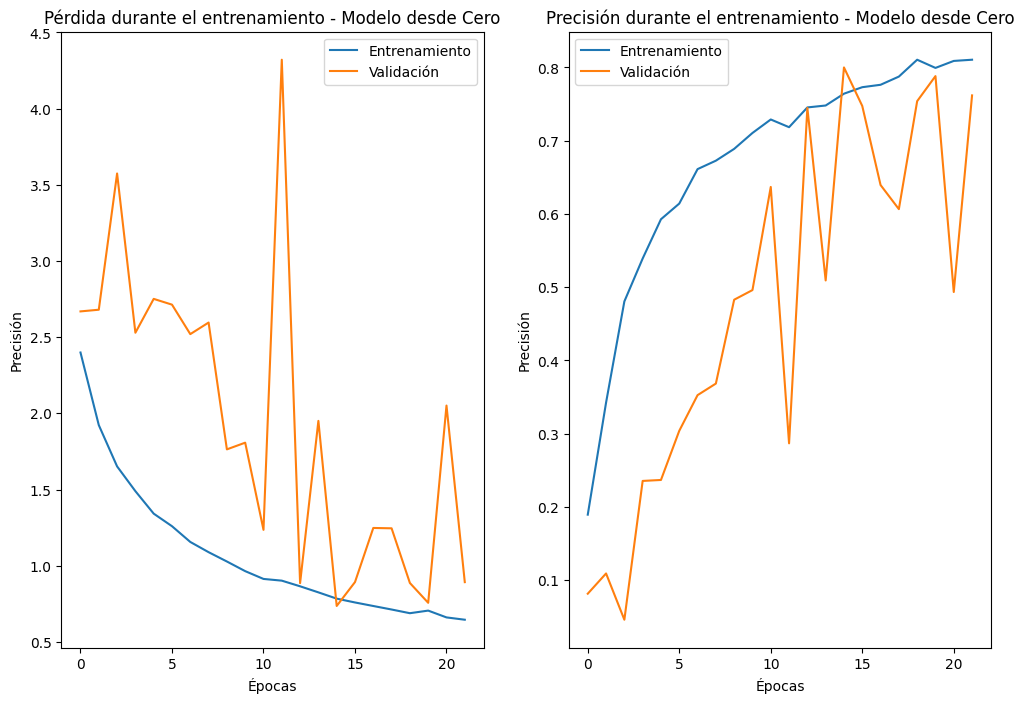

In [ ]:
plot_training(history_alternative_1, 'Modelo desde Cero')

Evaluando el modelo de predicción con las imágenes de test

In [46]:
model_test_alternative_1 = model_aternative_1.predict(test_dataset, batch_size=32)
print(classification_report(y_test, model_test_alternative_1.argmax(axis=1)))

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 526ms/step
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        53
           1       0.75      0.92      0.83        78
           2       0.85      0.86      0.85        58
           3       0.99      0.62      0.76       122
           4       0.80      0.93      0.86        44
           5       0.85      0.88      0.87        95
           6       0.86      0.66      0.74       131
           7       0.97      0.70      0.82        44
           8       0.76      0.93      0.84       103
           9       0.36      0.28      0.32        46
          10       0.69      0.93      0.79        99
          11       0.90      0.91      0.90        77

    accuracy                           0.78       950
   macro avg       0.77      0.77      0.76       950
weighted avg       0.80      0.78      0.78       950



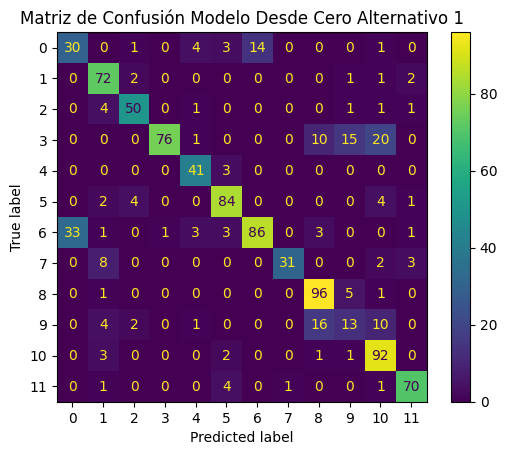

In [47]:
y_pred_model_aternative_1 = np.argmax(model_test_alternative_1, axis=1)
cf_model = confusion_matrix(y_test, y_pred_model_aternative_1)

mn_disp = ConfusionMatrixDisplay(cf_model)
mn_disp.plot()
plt.title('Matriz de Confusión Modelo Desde Cero Alternativo 1')
plt.show()

## 5.2 Evaluación de resultados con pre-procesamiento de imagenes utilizando segmentación para eliminación de fondo

Extraemos las plantas mediante máscara HSV con eliminación de fondo

In [67]:
import cv2
from scipy import ndimage

def apply_hsv_mask(
    image_rgb,
    lower_green=[25, 40, 50],
    upper_green=[75, 255, 255]):

    img_rgb = (image_rgb * 255).astype(np.uint8)

    blurred = cv2.GaussianBlur(img_rgb, (5, 5), 0)

    img_bgr = cv2.cvtColor(blurred, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    lower_bound = np.array(lower_green, dtype=np.uint8)
    upper_bound = np.array(upper_green, dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    bMask = mask > 0

    result = np.zeros_like(img_bgr)
    result[bMask] = img_bgr[bMask]

    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result_rgb.astype('float32') / 255.0

Adaptamos la máscara HSV para pipelines de TensorFlow

In [68]:
def tf_apply_hsv_mask(image):

    def py_hsv_mask(img):
        img_np = img.numpy()
        masked = apply_hsv_mask(img_np)
        return masked.astype(np.float32)

    masked_image = tf.py_function(py_hsv_mask, [image], tf.float32)
    masked_image.set_shape([224, 224, 3])
    return masked_image

Cargamos y preprocesamos imágenes con segmentación y augmentación

In [69]:
def tf_load_image(path, label, is_training=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0

    # Resize
    img = tf.image.resize(img, (224, 224))

    # HSV mask
    img = tf_apply_hsv_mask(img)

    # Augmentation
    if is_training:
        img = data_augmentation(img)

    label = tf.one_hot(label, depth=12)
    return img, label

Creamos datasets optimizados de train/val/test con segmentación HSV

In [70]:
# TRAIN
train_dataset_hsv = tf.data.Dataset.from_tensor_slices((X_dev_train.values, y_dev_train.values))
train_dataset_hsv = train_dataset_hsv.map(
    lambda x, y: tf_load_image(x, y, is_training=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset_hsv = train_dataset_hsv.shuffle(len(X_dev_train)).batch(32).prefetch(tf.data.AUTOTUNE)

# VALIDATION
val_dataset_hsv = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val_dataset_hsv = val_dataset_hsv.map(
    lambda x, y: tf_load_image(x, y, is_training=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset_hsv = val_dataset_hsv.batch(32).prefetch(tf.data.AUTOTUNE)

# TEST
test_dataset_hsv = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_dataset_hsv = test_dataset_hsv.map(
    lambda x, y: tf_load_image(x, y, is_training=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset_hsv = test_dataset_hsv.batch(32).prefetch(tf.data.AUTOTUNE)

Realizamos una inspección visual de algunas imágenes de los datasets

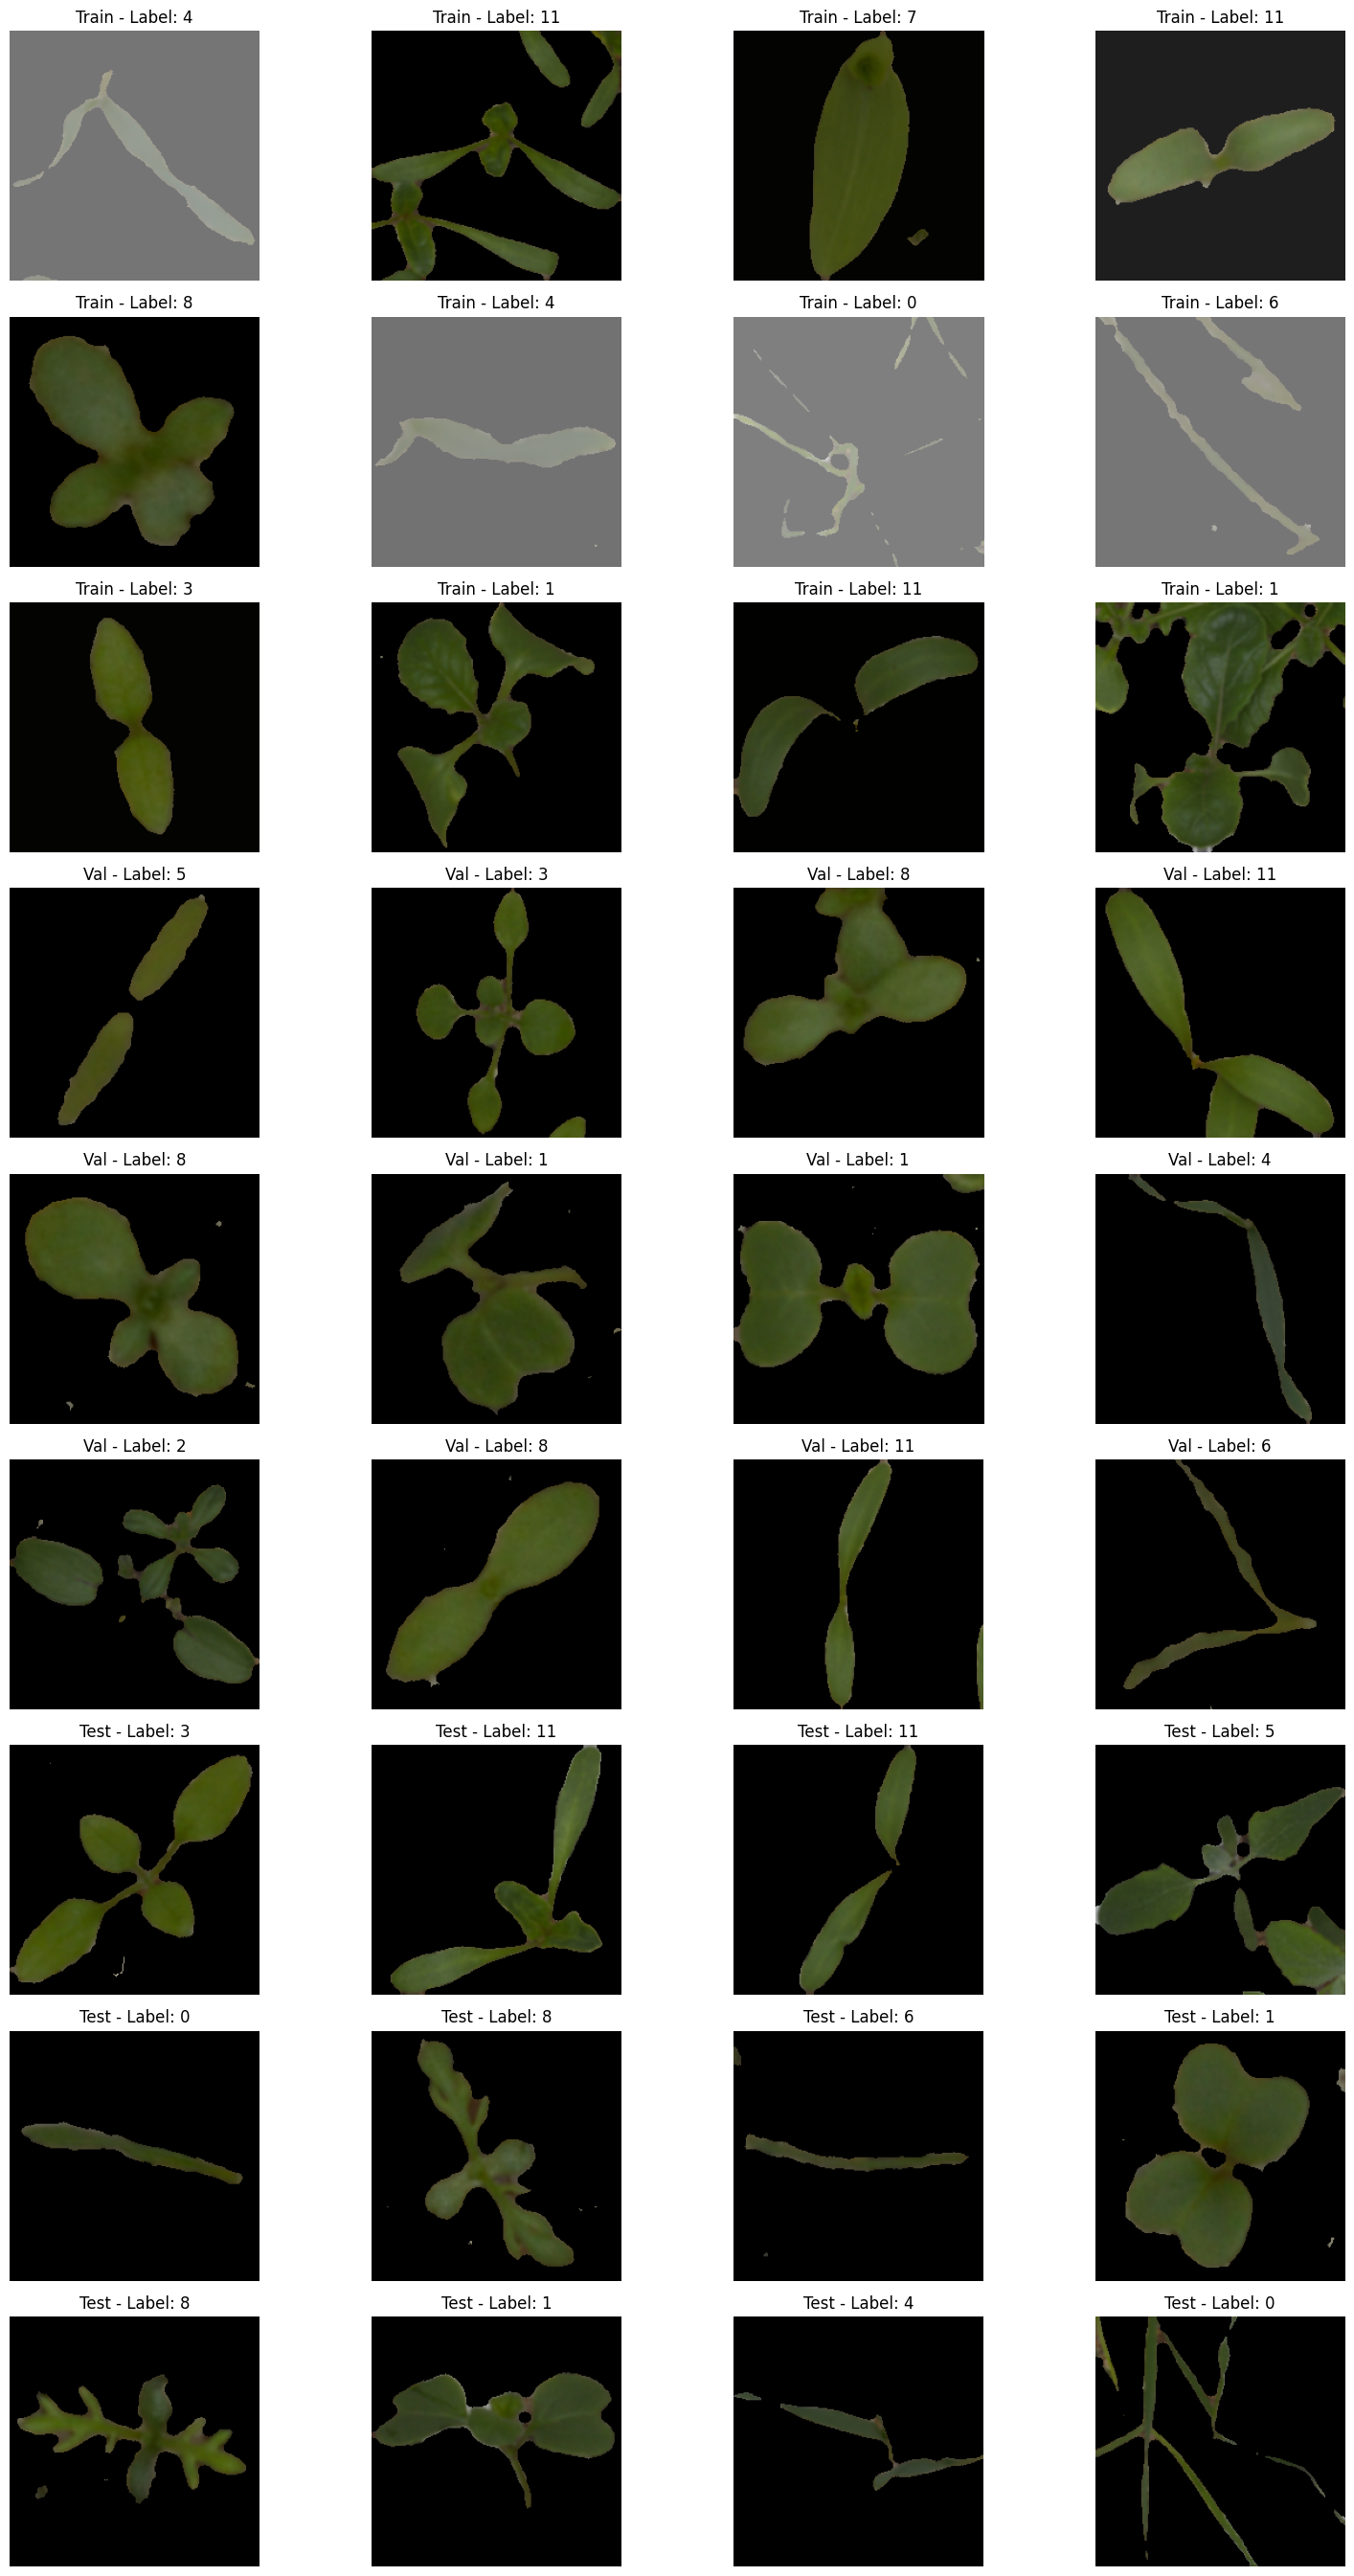

In [71]:
def get_random_samples(dataset, n=3):
    all_images = []
    all_labels = []

    for images, labels in dataset.take(2):
        all_images.append(images)
        all_labels.append(labels)

    all_images = tf.concat(all_images, axis=0).numpy()
    all_labels = tf.concat(all_labels, axis=0).numpy()

    indices = np.random.choice(len(all_images), n, replace=False)
    return all_images[indices], all_labels[indices]

n_images = 12
train_imgs, train_labels = get_random_samples(train_dataset_hsv, n=n_images)
val_imgs, val_labels = get_random_samples(val_dataset_hsv, n=n_images)
test_imgs, test_labels = get_random_samples(test_dataset_hsv, n=n_images)

n_cols = 4
n_rows_per_dataset = int(np.ceil(n_images / n_cols))
total_rows = n_rows_per_dataset * 3

fig, axes = plt.subplots(total_rows, n_cols, figsize=(16, total_rows * 3))

datasets = [
    (train_imgs, train_labels, 'Train'),
    (val_imgs, val_labels, 'Val'),
    (test_imgs, test_labels, 'Test')
]

for dataset_idx, (imgs, labels, name) in enumerate(datasets):
    start_row = dataset_idx * n_rows_per_dataset

    for i in range(n_images):
        row = start_row + (i // n_cols)
        col = i % n_cols

        img = imgs[i]
        label = labels[i]

        if img.min() < 0:
            img = (img + 1) / 2

        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{name} - Label: {np.argmax(label)}')
        axes[row, col].axis('off')

    # Ocultar ejes vacíos si los hay
    for i in range(n_images, n_rows_per_dataset * n_cols):
        row = start_row + (i // n_cols)
        col = i % n_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### 5.2.1 Entrenamiento de Modelo

In [53]:
# Configuramos Modelo
with tf.device('/GPU:0'):
    model_hsv = image_classificator()
    optimizer = Adam(learning_rate=0.0005)  # LR un poco más alto

    model_hsv.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [54]:
history_hsv = model_hsv.fit(
    train_dataset_hsv,
    epochs=50,
    validation_data=val_dataset_hsv,
    verbose=1,
    callbacks=[early_stopping,checkpoint_sm],
    class_weight=class_weight_dict
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1138 - loss: 2.5242
Epoch 1: val_accuracy did not improve from 0.67237
95/95 ━━━━━━━━━━━━━━━━━━━━ 70s 181ms/step - accuracy: 0.1142 - loss: 2.5225 - val_accuracy: 0.0842 - val_loss: 2.5540
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2364 - loss: 2.1116
Epoch 2: val_accuracy did not improve from 0.67237
95/95 ━━━━━━━━━━━━━━━━━━━━ 74s 178ms/step - accuracy: 0.2367 - loss: 2.1109 - val_accuracy: 0.0605 - val_loss: 3.1350
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2956 - loss: 1.9144
Epoch 3: val_accuracy did not improve from 0.67237
95/95 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy: 0.2957 - loss: 1.9138 - val_accuracy: 0.1434 - val_loss: 3.7625
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3846 - loss: 1.6819
Epoch 4: val_accuracy did not improve from 0.67237
95/95 ━━━━━━━━━━━━━━━━━━━━ 55s 163ms/step - accuracy: 0.3847 - loss: 1.6821 - val_accuracy: 0.0961 - v

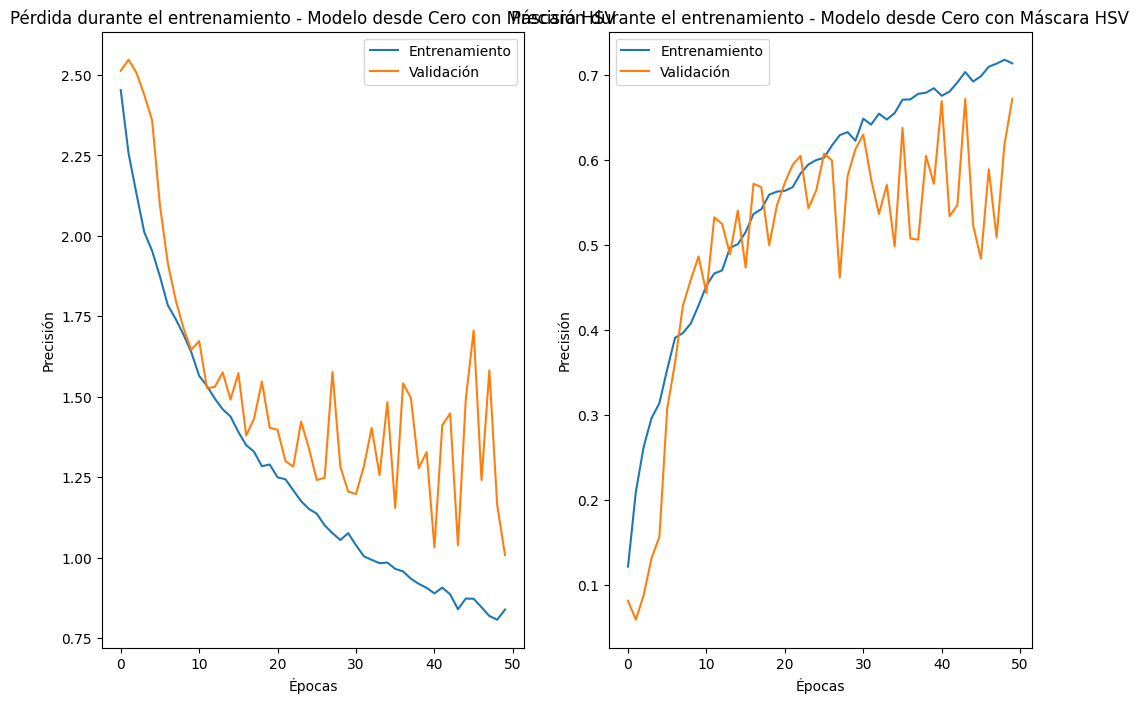

In [55]:
plot_training(history_hsv, 'Modelo desde Cero con Máscara HSV')

Guardamos los pesos del modelo

In [65]:
weights_path = os.path.join(MODEL_DIR, 'model_hsv.weights.h5')
model_hsv.save_weights(weights_path)
print(f"Pesos guardados: {weights_path}")

Pesos guardados: /content/drive/MyDrive/Colab Notebooks/models/model_hsv.weights.h5


#### 5.2.2 Validación de Resultados

In [59]:
predictions_hsv = model_hsv.predict(test_dataset_hsv, batch_size=32)
print(classification_report(y_test, predictions_hsv.argmax(axis=1)))

30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step
              precision    recall  f1-score   support

           0       0.48      0.60      0.54        53
           1       0.95      0.72      0.82        78
           2       0.79      0.91      0.85        58
           3       0.81      0.95      0.88       122
           4       0.61      0.91      0.73        44
           5       0.91      0.74      0.81        95
           6       0.81      0.77      0.79       131
           7       0.94      0.75      0.84        44
           8       0.85      0.83      0.84       103
           9       0.78      0.61      0.68        46
          10       0.86      0.97      0.91        99
          11       0.95      0.81      0.87        77

    accuracy                           0.81       950
   macro avg       0.81      0.80      0.80       950
weighted avg       0.83      0.81      0.81       950



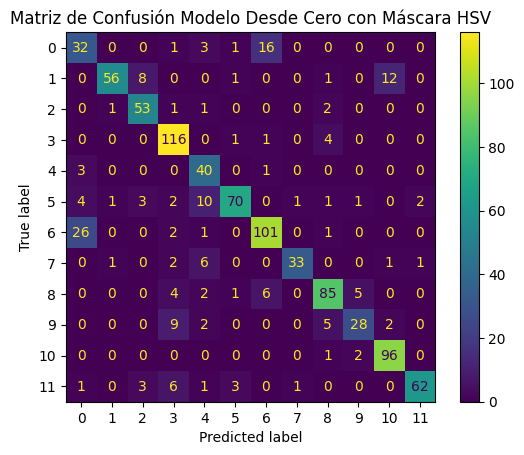

In [60]:
y_pred_model_hsv = np.argmax(predictions_hsv, axis=1)
cf_model_hsv = confusion_matrix(y_test,y_pred_model_hsv)

mn_disp_hsv = ConfusionMatrixDisplay(cf_model_hsv)
mn_disp_hsv.plot()
plt.title('Matriz de Confusión Modelo Desde Cero con Máscara HSV')
plt.show()

## 6. Bibilografía

- [1] keras.applications: https://keras.io/api/applications/

- [2] A snapshot of image pre-processing for convolutional neural networks: case study of MNIST
- [3] Master These 5 Essential Tips for Preprocessing Image Data
- [4] An empirical study of preprocessing techniques with convolutional neural networks for accurate detection of chronic ocular diseases using fundus images

In [ ]:
pip install jupyter nbconvert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00


In [ ]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java 

In [ ]:
jupyter nbconvert --to pdf --no-execute 07MIAR_Proyecto_Programacion_Grupo8.ipynb


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (ipython-input-376207462.py, line 1)